which conditionings are possible?
1. weekend / weekday is possible because we have columns "acc_weekday_type_count_weekday" and "acc_weekday_type_count_weekend" for accidents and for the strava data we have weekday
2. In general we can do weekday / weekend/weekday / monthly / yearly / seasonal (all temporal features that we have)
3. lighting condition / time of day is not possible because strava data has missing values / incorrect values for time of day (adding all possible time days does not equal total ride counts)

In [30]:
import geopandas as gpd
df = gpd.read_parquet(path="../data/merged/berlin_bike_accident_strava_risk_core_panel.parquet")

In [ ]:
# sanity check number of accidents
mask = df["total_accidents"] == df["acc_weekday_type_count_weekday"] + df["acc_weekday_type_count_weekend"]
print(len(df))
print(sum(mask))

297480
297480


from df we can get share of weekday/weekend accidents -> calculate count of weekday/weekend accidents -> from strava panel get weekday/weekend counts -> aggregate for month year

In [32]:
# counter_name year month sum_strava_total_trip_count total_accidents acc_weekday_type_share_weekday, acc_weekday_type_share_weekend
keep_cols = ["counter_name", "year", "month", "sum_strava_total_trip_count",
            "total_accidents", "acc_weekday_type_share_weekday", "acc_weekday_type_share_weekend"]
df = df.loc[:, keep_cols]

df["acc_count_weekday"] = df["total_accidents"] * df["acc_weekday_type_share_weekday"]
df["acc_count_weekend"] = df["total_accidents"] * df["acc_weekday_type_share_weekend"]

df["counter_name"] = df['counter_name'].str.replace('streetsegment_', '', regex=False).astype(int)
df = df.loc[:, ["counter_name", "year", "month", "acc_count_weekday", "acc_count_weekend"]]
agg_acc_df = df.groupby("counter_name", as_index=False)[["acc_count_weekday", "acc_count_weekend"]].sum()

In [33]:
agg_acc_df.head()

,counter_name,acc_count_weekday,acc_count_weekend
0,0,12.0,4.0
1,1,0.0,0.0
2,2,0.0,0.0
3,3,0.0,0.0
4,4,7.0,0.0


strava panel loading and calculating weekday / weekend traffic volumnes

In [9]:
import pandas as pd
strava_data_all = pd.read_parquet(path="../data/strava_data/berlin_data.parquet")

In [ ]:
# select relevant columns and preprocess
strava_data = strava_data_all.loc[:, ["counter_name", "strava_total_trip_count", "month", "year", "is_weekend"]]
strava_data = strava_data.rename(columns={'strava_total_trip_count': 'count'})
strava_data['month'] = strava_data['month'].str.replace('month_is_', '', regex=False).astype(int)
strava_data['year'] = strava_data['year'].str.replace('year_is_', '', regex=False).astype(int)
strava_data["counter_name"] = strava_data['counter_name'].str.replace('streetsegment_', '', regex=False).astype(int)

# aggregate
aggregated_df = strava_data.groupby(['month', 'year', 'counter_name', 'is_weekend'], as_index=False)['count'].sum()

# fuse together is weekend = True and is weekend = False rows -> one row for each month/year/countername
result_df = aggregated_df.pivot_table(
    index=['year', 'month', 'counter_name'],
    columns='is_weekend',
    values='count',
    aggfunc='sum'
).reset_index()

# Rename the columns for clarity
result_df.columns.name = None  # Remove the 'is_weekend' label
result_df = result_df.rename(columns={False: 'count_weekday', True: 'count_weekend'})

# Aggregate counts over all months and years for each counter_name
final_df = result_df.groupby('counter_name', as_index=False)[['count_weekday', 'count_weekend']].sum()

# create new columns
final_df["total_count"] = final_df["count_weekday"] + final_df["count_weekend"]
final_df["share_weekday"] = final_df["count_weekday"] / final_df["total_count"]
final_df["share_weekend"] = final_df["count_weekend"] / final_df["total_count"]

# remove where count is zero
final_df = final_df.dropna()

<Axes: >

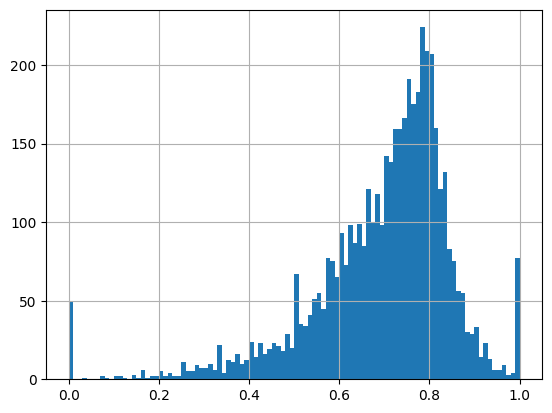

In [ ]:
# sanity check the distribution
final_df.share_weekday.hist(bins=100)

inner join on both dataframes (strava weekday/weekend counts + accident weekday/weekend counts)

In [48]:
merged_df = pd.merge(final_df, agg_acc_df, on='counter_name', how='inner')

In [ ]:
merged_df = merged_df.rename(columns={"count_weekday": "strava_count_weekday",
                                      "count_weekend": "strava_count_weekend",
                                      "share_weekday": "strava_share_weekday",
                                      "share_weekend": "strava_share_weekend",
                                      "total_count": "strava_total_count",
                                      })
# dont divide by zero
mask = (merged_df.strava_count_weekend > 0.0) & (merged_df.strava_count_weekday > 0.0)
merged_df = merged_df[mask]

# calculate risk
merged_df["risk_weekday"] = merged_df.acc_count_weekday / merged_df.strava_count_weekday
merged_df["risk_weekend"] = merged_df.acc_count_weekend / merged_df.strava_count_weekend

# add total acc count
merged_df["acc_total_count"] = merged_df.acc_count_weekday + merged_df.acc_count_weekend

In [ ]:
# filtering out data (what data do we want to exclude / include??)
mask = (merged_df.risk_weekend > 0.0) & (merged_df.risk_weekday > 0.0) & (merged_df.strava_count_weekend > 500.0) # only get frequented segments and exclude zero risk segments
less_data_df = merged_df[mask]
len(less_data_df)

1129

wilcoxon singed rank test (non-parametric :D )

In [ ]:
from scipy.stats import wilcoxon
# performing a wilcoxon signed rank test (see lecture notes)
# to see if risk distributions are equal or not
wilcoxon(less_data_df.risk_weekday, less_data_df.risk_weekend)

WilcoxonResult(statistic=np.float64(301557.0), pvalue=np.float64(0.12427921453814779))

plotting conditional (weekday/weekend) risk distributions

<Axes: >

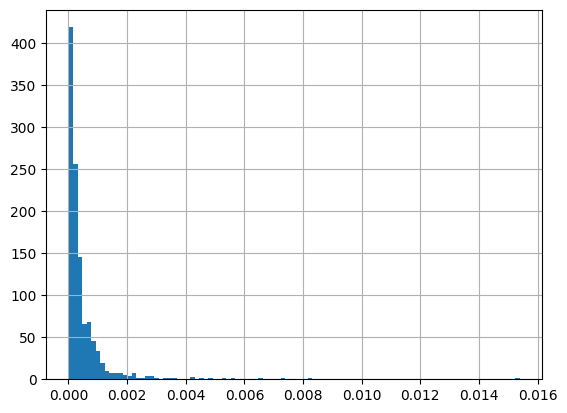

In [ ]:
less_data_df.risk_weekday.hist(bins=100)

<Axes: >

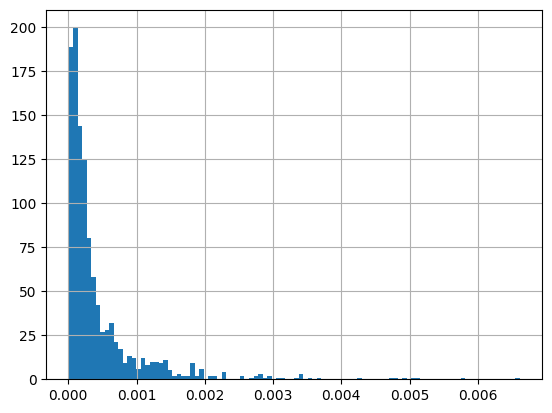

In [93]:
less_data_df.risk_weekend.hist(bins=100)